<a href="https://colab.research.google.com/github/wvirany/microbiome/blob/main/Virany_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predicting Microbiome-Phenotype Associations in the Human Gut

#### See the [blog post](https://wvirany.github.io/posts/microbiome)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, confusion_matrix, RocCurveDisplay
from sklearn.linear_model import LassoCV, ElasticNetCV

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

np.random.seed(1984)

---
## Data Loading and Preprocessing

Load the data as a pandas dataframe, explore the structure of the data, and perform some transformations.

In [74]:
ibd = pd.read_csv("data/ibd_rel_abundance.csv")
healthy = pd.read_csv("data/healthy_rel_abundance.csv")

In [75]:
print(ibd.shape)
ibd.head()

(1201, 579)


,Phocaeicola vulgatus,Bacteroides uniformis,Bacteroides thetaiotaomicron,Faecalibacterium prausnitzii,Roseburia faecis,Bacteroides caccae,Enterocloster clostridioformis,Bacteroides fragilis,Fusicatenibacter saccharivorans,Flavonifractor plautii,...,Prevotella histicola,Prevotella pallens,Chlamydia ibidis,Enterococcus mundtii,Anaerostipes sp. 992a,Actinobaculum sp. oral taxon 183,Lachnoclostridium sp. An298,Haemophilus haemolyticus,Enterococcus dispar,Atopobium minutum
0,8436640,6235541,1357098,1054351,999360,551484,334448,168192,139201,133264,...,0,0,0,0,0,0,0,0,0,0
1,17080974,9468596,2861845,189087,190713,479440,315591,182143,268493,427323,...,0,0,0,0,0,0,0,0,0,0
2,12088033,14919763,7543241,452106,455094,1991901,537137,7969977,5346,185637,...,0,0,0,0,0,0,0,0,0,0
3,9174317,15253970,4019070,988736,429513,964149,46820,3271311,37552,86170,...,0,0,0,0,0,0,0,0,0,0
4,3662205,8560295,7882055,817546,814911,686063,27640,4984518,9446,411733,...,0,0,0,0,0,0,0,0,0,0


In [76]:
print(healthy.shape)
healthy.head()

(426, 579)


,Phocaeicola vulgatus,Bacteroides uniformis,Bacteroides thetaiotaomicron,Faecalibacterium prausnitzii,Roseburia faecis,Bacteroides caccae,Enterocloster clostridioformis,Bacteroides fragilis,Fusicatenibacter saccharivorans,Flavonifractor plautii,...,Prevotella histicola,Prevotella pallens,Chlamydia ibidis,Enterococcus mundtii,Anaerostipes sp. 992a,Actinobaculum sp. oral taxon 183,Lachnoclostridium sp. An298,Haemophilus haemolyticus,Enterococcus dispar,Atopobium minutum
0,3533802,0,1337816,687547,53255,715021,0,372727,65730,0,...,0,0,0,0,0,0,0,0,0,0
1,6064315,0,3210841,1360390,170153,988210,0,556607,6110,0,...,0,0,0,0,0,0,0,0,0,0
2,8981714,417246,2959316,3261926,428559,2618916,0,378112,43182,3868,...,0,0,0,0,0,0,0,0,0,0
3,4846186,668638,127925,1308172,247559,445041,0,0,85596,77852,...,0,0,0,0,0,0,0,0,0,0
4,3127461,0,1190156,1030098,126186,804786,0,135517,47591,0,...,0,0,0,0,0,0,0,0,0,0


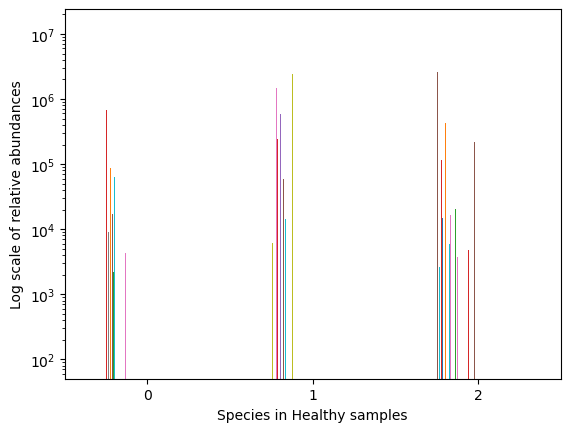

In [77]:
# Histogram of the first 3 elements of the healthy dataframe
healthy[:3].plot(kind='bar', legend=False, logy=True, xlabel='Species in Healthy samples', ylabel='Log scale of relative abundances', rot=0);

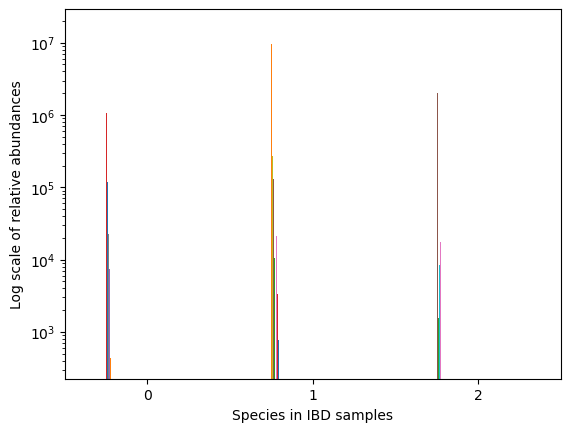

In [78]:
# Histogram of the first 3 elements of the IBD dataframe
ibd[:3].plot(kind='bar', legend=False, logy=True, xlabel='Species in IBD samples', ylabel='Log scale of relative abundances', rot=0);

In [79]:
healthy.insert(0, 'IBD', 0); # 0 for control sample
ibd.insert(0, 'IBD', 1); # 1 for case sample

In [80]:
data = pd.concat([ibd, healthy]).sample(frac=1).set_index(np.arange(0, 1627))

In [81]:
data.shape

(1627, 580)

In [82]:
data.head()

,IBD,Phocaeicola vulgatus,Bacteroides uniformis,Bacteroides thetaiotaomicron,Faecalibacterium prausnitzii,Roseburia faecis,Bacteroides caccae,Enterocloster clostridioformis,Bacteroides fragilis,Fusicatenibacter saccharivorans,...,Prevotella histicola,Prevotella pallens,Chlamydia ibidis,Enterococcus mundtii,Anaerostipes sp. 992a,Actinobaculum sp. oral taxon 183,Lachnoclostridium sp. An298,Haemophilus haemolyticus,Enterococcus dispar,Atopobium minutum
0,0,2272063,2001721,276982,1345281,268172,852782,0,479700,37906,...,0,0,0,0,0,0,0,0,0,0
1,1,3013282,5677365,770879,2034017,1201494,726564,28201,1043,206893,...,0,0,0,0,0,0,0,0,0,0
2,0,2277293,1626446,0,751116,369914,849899,0,0,43675,...,0,0,0,0,0,0,0,0,0,0
3,1,3217392,1255208,20792,3731832,0,729289,0,5680,344440,...,0,0,0,0,0,0,0,0,0,0
4,0,18757778,8321377,0,4941293,1387587,0,0,1853816,71087,...,0,0,0,0,0,0,0,0,0,0


In [83]:
# Replace brackets in column names
data.columns = data.columns.str.replace('[', '').str.replace(']', '')

In [84]:
train, val, test = np.split(data.sample(frac=1), [int(.8*len(data)), int(.9*len(data))])

In [85]:
X_train = train.drop('IBD', axis=1).fillna(0) # Features
y_train = train['IBD'] # Targets

X_val = val.drop('IBD', axis=1).fillna(0)
y_val = val['IBD']

X_test = test.drop('IBD', axis=1).fillna(0)
y_test = test['IBD']

In [86]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(1301, 579) (1301,)
(163, 579) (163,)
(163, 579) (163,)


---

## Feature Selection w/ LASSO and ElasticNet



In [87]:
steps = [
    ('scaler', MinMaxScaler()),  # Data preprocessing step
    ('classifier', SVC(C=2048, gamma=.5, kernel='rbf', random_state=1))  # Model step
]

svm_base = Pipeline(steps)

svm_base.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier', SVC(C=2048, gamma=0.5, random_state=1))])

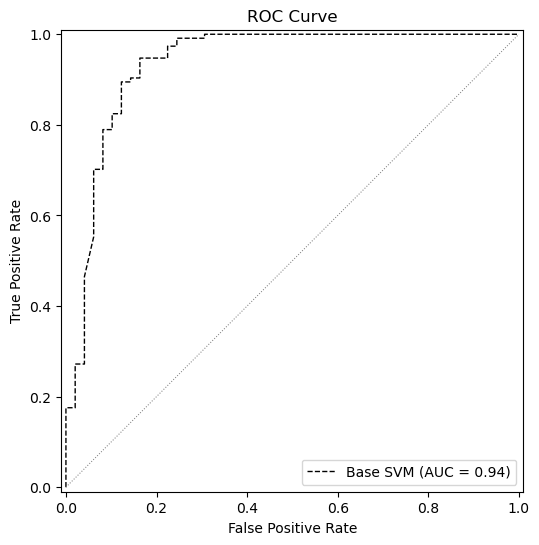

In [89]:
fig, ax = plt.subplots(figsize=(8, 6))

fig_params = {'estimator' : svm_base,
              'name' : 'Base SVM',
              'X' : X_test,
              'y' : y_test,
              'ax' : ax,
              'c' : 'black',
              'ls' : 'dashed',
              'lw' : 1}

RocCurveDisplay.from_estimator(**fig_params)
ax.plot([0,1], c='gray', ls='dotted', lw=.75)

ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

plt.show();

In [90]:
%%capture

alphas = [10**(x) for x in np.arange(-4, 0, step=.5)]

lassoCV = LassoCV(cv = 5,
                  alphas=alphas,
                  random_state=42).fit(X_train, y_train)

In [91]:
lassoCV.alpha_

0.31622776601683794

In [92]:
l1_ratios = [.1, .5, .7, .9, .95, .99, 1]

enetCV = ElasticNetCV(l1_ratio=l1_ratios,
                      alphas=alphas,
                      cv=5,
                      random_state=1984).fit(X_train, y_train)

In [93]:
enetCV.l1_ratio_

1.0

In [94]:
X_lasso = data.drop(['IBD'], axis=1).copy()
coefs = lassoCV.coef_.copy()

while(int(np.min(np.abs(coefs)) == 0)):
    idx = np.argmin(np.abs(coefs))
    X_lasso = X_lasso.drop(X_lasso.columns[idx], axis=1)
    coefs = np.delete(coefs, idx)

In [95]:
X_lasso.shape

(1627, 444)

In [96]:
X_train_lasso = X_train[X_lasso.columns]
X_val_lasso = X_val[X_lasso.columns]
X_test_lasso = X_test[X_lasso.columns]

In [97]:
X_train_lasso.shape, X_val_lasso.shape, X_test_lasso.shape

((1301, 444), (163, 444), (163, 444))

In [98]:
# Redefine steps to incorporate randomness into the model
steps = [
    ('scaler', MinMaxScaler()),  # Data preprocessing step
    ('classifier', SVC(C=2048, gamma=.5, kernel='rbf'))  # Model step
]

In [99]:
percentiles = [.1 * x for x in np.arange(10)]

total_coefs = coefs.size
svm_scores = np.zeros(len(percentiles))

for i, percent in enumerate(percentiles):

    columns = []
    lasso_coefs = coefs.copy()
    d = X_lasso.copy()

    # Contructing the dataset with top p percent of features included:
    for _ in range(int((1-percent) * total_coefs)):
        # Get index of most important feature, append to columns
        idx = np.argmax(np.abs(lasso_coefs))
        columns.append(d.columns[idx])
        # Remove feature from list to search for next most important feature
        lasso_coefs = np.delete(lasso_coefs, idx)
        d.drop(d.columns[idx], axis=1, inplace=True)

    # Construct train and validation sets on new subset of features
    train = X_train_lasso[columns]
    val = X_val_lasso[columns]

    # Training / testing and averaging results:
    for _ in range(20):
        svm = Pipeline(steps)
        svm.fit(train, y_train)
        svm_scores[i] += roc_auc_score(y_val, svm.decision_function(val)) / 20

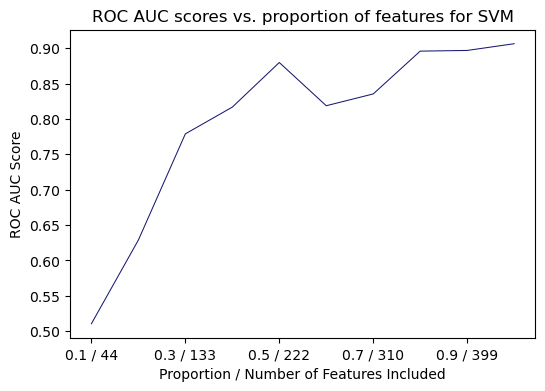

In [100]:
fig, ax = plt.subplots(figsize=(6, 4))

ticks = [0.0, 0.2, 0.4, 0.6, 0.8]
labels = ['0.1 / 44', '0.3 / 133', '0.5 / 222', '0.7 / 310', '0.9 / 399']

ax.plot(percentiles[::-1], svm_scores, label='Lasso Features', c='midnightblue', lw=.75)
ax.set_xlabel('Proportion / Number of Features Included')
ax.set_xticks(ticks, labels)
ax.set_ylabel('ROC AUC Score')
ax.set_title('ROC AUC scores vs. proportion of features for SVM');

In [101]:
columns = []
lasso_coefs = coefs.copy()
d = X_lasso.copy()

for _ in range(int(.2 * total_coefs)):
    idx = np.argmax(np.abs(lasso_coefs))
    columns.append(d.columns[idx])
    lasso_coefs = np.delete(lasso_coefs, idx)
    d.drop(d.columns[idx], axis=1, inplace=True)

train30 = X_train_lasso[columns]
val30 = X_val_lasso[columns]
test30 = X_test_lasso[columns]

In [102]:
steps = [
    ('scaler', MinMaxScaler()),  # Data preprocessing step
    ('classifier', SVC(C=2048, gamma=.5, kernel='rbf', random_state=42))  # Model step
]

In [103]:
svm_lasso = Pipeline(steps)
svm_lasso.fit(train30, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier', SVC(C=2048, gamma=0.5, random_state=42))])

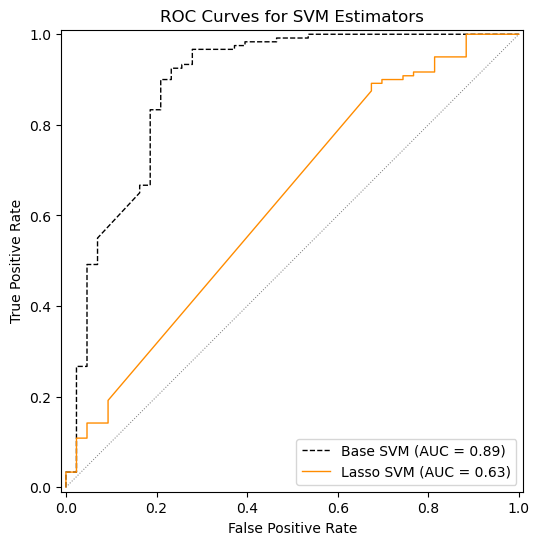

In [104]:
fig, ax = plt.subplots(figsize=(8, 6))

fig_params1 = {'estimator' : svm_base,
              'name' : 'Base SVM',
              'X' : X_val,
              'y' : y_val,
              'ax' : ax,
              'c' : 'black',
              'ls' : 'dashed',
              'lw' : 1}

fig_params2 = {'estimator' : svm_lasso,
              'name' : 'Lasso SVM',
              'X' : val30,
              'y' : y_val,
              'ax' : ax,
              'c' : 'darkorange',
              'ls' : 'solid',
              'lw' : 1}

RocCurveDisplay.from_estimator(**fig_params1)
RocCurveDisplay.from_estimator(**fig_params2)
ax.plot([0,1], c='gray', ls='dotted', lw=.75)

ax.set_title('ROC Curves for SVM Estimators')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

plt.show();

---

## Random Forests

In [105]:
# No significant difference when optimizing hyperparameters with grid search:

# rf_params = {'n_estimators': [50, 75, 100, 150, 200, 300, 400, 500],
#              'criterion': ['gini', 'entropy', 'log_loss'],
#              'max_features': ['sqrt', 'log2', None],
#              'class_weight': ['balanced', None],
#              'random_state': [1]}

# rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, refit=True, cv=5)

# rf_grid.fit(X_train, y_train)

In [106]:
rf = RandomForestClassifier(n_estimators=500,
                            criterion='gini',
                            max_features='sqrt',
                            class_weight='balanced',
                            random_state=1984).fit(X_train, y_train)

In [107]:
feature_importances = rf.feature_importances_

In [108]:
num_features = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150, 175, 200]
rf_scores = []

for k in num_features:
    K_train = X_train.copy()
    K_val = X_val.copy()
    features = feature_importances

    # Contrstructing list of top k features by dropping lowest 579 - k features:
    for i in range(579 - k):
        idx = np.argmin(features)
        K_train = K_train.drop(K_train.columns[idx], axis=1)
        features = np.delete(features, idx)

    rf_temp = RandomForestClassifier(n_estimators=500,
                                     criterion='gini',
                                     max_features='sqrt',
                                     class_weight='balanced',
                                     random_state=1984).fit(K_train, y_train)
    
    K_val = K_val[K_train.columns]

    rf_scores.append(rf_temp.score(K_val, y_val))

k = num_features[np.argmax(rf_scores)]

print(f"k = {k}")

k = 200


In [109]:
features = feature_importances

K_train = X_train.copy()
K_val = X_val.copy()

for i in range(579 - k):
    idx = np.argmin(features)
    K_train = K_train.drop(K_train.columns[idx], axis=1)
    features = np.delete(features, idx)

K_val = K_val[K_train.columns]

rf = RandomForestClassifier(n_estimators=500,
                            criterion='gini',
                            max_features='sqrt',
                            class_weight='balanced',
                            random_state=1984).fit(K_train, y_train)

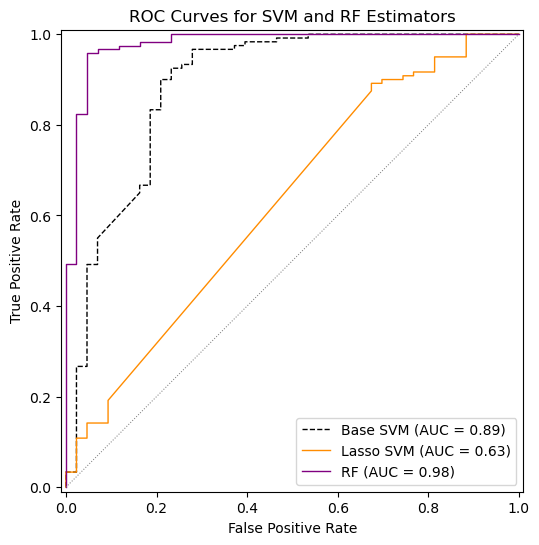

In [110]:
fig, ax = plt.subplots(figsize=(8, 6))

fig_params1 = {'estimator' : svm_base,
              'name' : 'Base SVM',
              'X' : X_val,
              'y' : y_val,
              'ax' : ax,
              'c' : 'black',
              'ls' : 'dashed',
              'lw' : 1}

fig_params2 = {'estimator' : svm_lasso,
              'name' : 'Lasso SVM',
              'X' : val30,
              'y' : y_val,
              'ax' : ax,
              'c' : 'darkorange',
              'ls' : 'solid',
              'lw' : 1}

fig_params3 = {'estimator' : rf,
               'name' : 'RF',
               'X' : K_val,
               'y' : y_val,
               'ax' : ax,
               'c' : 'purple',
               'ls' : 'solid',
               'lw' : 1}

for i in [fig_params1, fig_params2, fig_params3]:
    RocCurveDisplay.from_estimator(**i)

ax.plot([0,1], c='gray', ls='dotted', lw=.75)

ax.set_xlim(-.01, 1.01)
ax.set_ylim(-.01, 1.01)

ax.set_title('ROC Curves for SVM and RF Estimators')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

plt.show();

In [111]:
from matplotlib.colors import LinearSegmentedColormap

# Create data for demonstration
data = np.random.rand(10, 10)

# Create a custom colormap that only uses the lighter half of the orange scale
colors = [(1, 1, 1),          # Start with white
         (1, 0.9, 0.8),       # Very light orange
         (1, 0.8, 0.6),       # Light orange
         (1, 0.7, 0.4),       # Medium-light orange
         (1, 0.5, 0.1)]       # Medium orange/

n_bins = 100  # Number of color gradations
custom_orange = LinearSegmentedColormap.from_list("custom_orange", colors, N=n_bins)

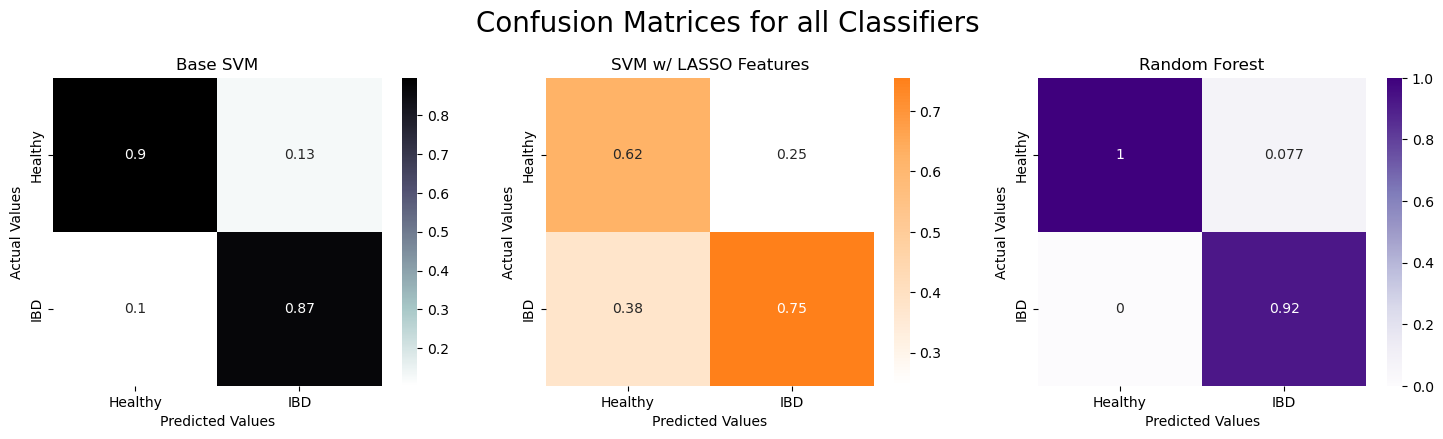

In [112]:
base_pred = svm_base.predict(X_val)
lasso_pred = svm_lasso.predict(val30)
rf_pred = rf.predict(K_val)

predictions = [base_pred, lasso_pred, rf_pred]
titles = ['Base SVM', 'SVM w/ LASSO Features', 'Random Forest']
cmaps = ['bone_r', custom_orange, 'Purples']

# Creating a confusion matrix for both linear and radial SVM classifier
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

for i in range(3):
    c = confusion_matrix(y_val, predictions[i], normalize='pred')
    axes[i] = sns.heatmap(c,
                          annot=True,
                          cmap=cmaps[i],
                          xticklabels=['Healthy', 'IBD'],
                          yticklabels=['Healthy', 'IBD'],
                          cbar=True,
                          ax=axes[i]);

    axes[i].set_ylabel('Actual Values')
    axes[i].set_xlabel('Predicted Values')
    axes[i].set_title(titles[i]);

fig.suptitle('Confusion Matrices for all Classifiers', y=1.05, fontsize=20);

In [113]:
# Setting model parameters

lgbm = LGBMClassifier(**{  'objective'           : 'binary',
                           'boosting_type'       : 'gbdt',
                           'metric'              : "auc",
                           'random_state'        : 42,
                           'colsample_bytree'    : 0.56,
                           'subsample'           : 0.35,
                           'learning_rate'       : 0.05,
                           'max_depth'           : 8,
                           'n_estimators'        : 1000,
                           'num_leaves'          : 140,
                           'reg_alpha'           : 0.14,
                           'reg_lambda'          : 0.85,
                           'verbosity'           : -1,
                          })
xgb  = XGBClassifier(**{  'objective'             : 'binary:logistic',
                          'eval_metric'           : "auc",
                          'random_state'          : 42,
                          'colsample_bytree'      : 0.25,
                          'learning_rate'         : 0.07,
                          'max_depth'             : 8,
                          'n_estimators'          : 800,
                          'reg_alpha'             : 0.09,
                          'reg_lambda'            : 0.70,
                          'min_child_weight'      : 22,
                          'verbosity'             : 0,
                         })
cat  = CatBoostClassifier(**{
                         'iterations'            : 10000,
                         'objective'             : 'Logloss',
                         'eval_metric'           : "AUC",
                         'early_stopping_rounds' : 1000,
                         'bagging_temperature'   : 0.1,
                         'colsample_bylevel'     : 0.88,
                         'iterations'            : 1000,
                         'learning_rate'         : 0.065,
                         'max_depth'             : 7,
                         'l2_leaf_reg'           : 1,
                         'min_data_in_leaf'      : 25,
                         'random_strength'       : 0.1,
                         'max_bin'               : 100,
                         'verbose'               : 0,
                        })
rf_vote = RandomForestClassifier(**{'n_estimators' : 500,
                               'criterion'    : 'gini',
                               'max_features' : 'sqrt',
                               'class_weight' : 'balanced',
                               'random_state' : 1984
                            })

models = [lgbm, xgb, cat, rf_vote]

In [114]:
vote = VotingClassifier(
    estimators=[('lgbm', lgbm), ('xgb', xgb), ('cat', cat), ('rf', rf)],
    voting='soft',
    weights = [2, 1, 1, .5]
)

steps = [
    ('scaler', MinMaxScaler()),  # Data preprocessing step
    ('model', vote)  # Model step
]

vote_20 = VotingClassifier(
    estimators=[('lgbm', lgbm), ('xgb', xgb), ('cat', cat), ('rf', rf)],
    voting='soft',
    weights = [2, 1, 1, .5]
)

steps_20 = [
    ('scaler', MinMaxScaler()),  # Data preprocessing step
    ('model', vote_20)  # Model step
]

In [115]:
num_features = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150, 175, 200]
clf_scores = []

for k in num_features:
    J_train = X_train.copy()
    J_val = X_val.copy()
    features = feature_importances

    # Contrstructing list of top k features by dropping lowest 579 - k features:
    for i in range(579 - k):
        idx = np.argmin(features)
        J_train = J_train.drop(J_train.columns[idx], axis=1)
        features = np.delete(features, idx)

    clf_temp = Pipeline(steps).fit(J_train, y_train)
    
    J_val = J_val[J_train.columns]

    clf_scores.append(clf_temp.score(J_val, y_val))

k = num_features[np.argmax(clf_scores)]

print(f"k = {k}")

k = 100


In [116]:
# Training classifier on k features
features = feature_importances

J_train = X_train.copy()
J_val = X_val.copy()

for i in range(579 - k):
    idx = np.argmin(features)
    J_train = J_train.drop(J_train.columns[idx], axis=1)
    features = np.delete(features, idx)

J_val = J_val[J_train.columns]

clf = Pipeline(steps).fit(J_train, y_train)

# Training classifier on 20 features
features = feature_importances

train20 = X_train.copy()
val20 = X_val.copy()

for i in range(579 - 20):
    idx = np.argmin(features)
    train20 = train20.drop(train20.columns[idx], axis=1)
    features = np.delete(features, idx)

val20 = val20[train20.columns]

clf20 = Pipeline(steps_20).fit(train20, y_train)

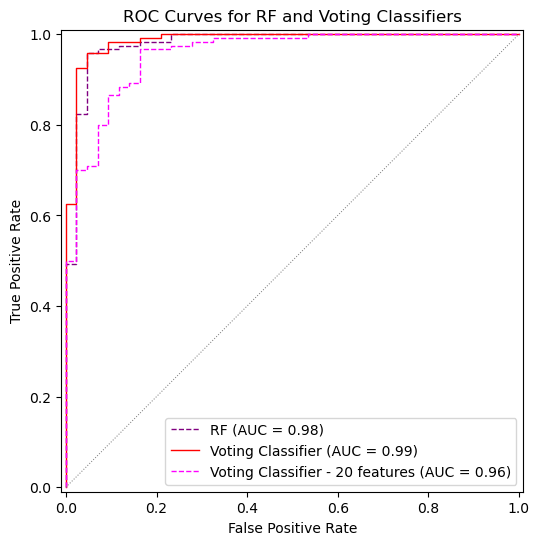

In [117]:
fig, ax = plt.subplots(figsize=(8, 6))

fig_params1 = {'estimator' : rf,
               'name' : 'RF',
               'X' : K_val,
               'y' : y_val,
               'ax' : ax,
               'c' : 'purple',
               'ls' : 'dashed',
               'lw' : 1}

fig_params2 = {'estimator' : clf,
               'name' : 'Voting Classifier',
               'X' : J_val,
               'y' : y_val,
               'ax' : ax,
               'c' : 'red',
               'ls' : 'solid',
               'lw' : 1}

fig_params3 = {'estimator' : clf20,
               'name' : 'Voting Classifier - 20 features',
               'X' : val20,
               'y' : y_val,
               'ax' : ax,
               'c' : 'magenta',
               'ls' : 'dashed',
               'lw' : 1}

for i in [fig_params1, fig_params2, fig_params3]:
    RocCurveDisplay.from_estimator(**i)

ax.plot([0,1], c='gray', ls='dotted', lw=.75)

ax.set_title('ROC Curves for RF and Voting Classifiers')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

plt.show();

In [118]:
K_test = X_test.copy()
J_test = X_test.copy()
test20 = X_test.copy()

K_test, J_test, test20 = K_test[K_train.columns], J_test[J_train.columns], test20[train20.columns]

In [ ]:
def get_metrics(model, X, y, svm=True):
    """Calculate classification metrics for a fitted model."""
    y_pred = model.predict(X)

    return {
        'ROC AUC': roc_auc_score(y, model.predict_proba(X)[:, 1]),
        'Accuracy': accuracy_score(y, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y, y_pred),
        'Precision': precision_score(y, y_pred),
        'F1 Score': f1_score(y, y_pred),
        'Recall': recall_score(y, y_pred)
    }

# Calculate metrics for each model on test set
models = {
    'RF (200 features)': (rf, K_test),
    'Voting Classifier (100 features)': (clf, J_test),
    'Voting Classifier (20 features)': (clf20, test20)
}

results = {name: get_metrics(model, X, y_test) 
          for name, (model, X) in models.items()}

# Create DataFrame for easy comparison
df_results = pd.DataFrame(results).round(3)

In [143]:
df_results.T.columns

Index(['ROC AUC', 'Accuracy', 'Balanced Accuracy', 'Precision', 'F1 Score',
       'Recall'],
      dtype='object')

In [147]:
original_study = [0.890, .78, '-', .78, .78, .81]
df_results['Original Study'] = original_study

In [148]:
df_results.T

,ROC AUC,Accuracy,Balanced Accuracy,Precision,F1 Score,Recall
RF (200 features),0.955,0.957,0.934,0.95,0.97,0.991
Voting Classifier (100 features),0.958,0.963,0.945,0.958,0.974,0.991
Voting Classifier (20 features),0.945,0.926,0.895,0.925,0.949,0.974
Original Study,0.89,0.78,-,0.78,0.78,0.81
